### Interpret Results

In [1]:
import sys
import os

def modify_sys_path():
    """
    Run this function to add the src directory to sys.path.
    """
    # Get the absolute path of the project root
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

    # Add the src directory to sys.path
    sys.path.append(project_root)

    return

def get_src_dir_path(path: str = None):
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    
    if path is None:
        return project_root
    else:
        return os.path.join(project_root, path)

In [2]:
modify_sys_path()

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re

from src.utils import calculate_kl_divergence

In [4]:
def calculate_kl_divergence_for_z_data(df: pd.DataFrame):
    kl_divergence_pyx_pyxz = []
    kl_divergence_pyxz_pyx = []

    PROB_LABELS = ["0", "1"]
    for index, row in df.iterrows():
        prob_y_x = {}
        prob_y_xz = {}
        for label in PROB_LABELS:
            prob_y_x[label] = row[f"p(y={label}|x,D)"]
            prob_y_xz[label] = row[f"p(y={label}|x,z,D)"]
        kl_divergence_pyx_pyxz.append(calculate_kl_divergence(prob_y_x, prob_y_xz))
        kl_divergence_pyxz_pyx.append(calculate_kl_divergence(prob_y_xz, prob_y_x))
        
    df["kl_pyx_pyxz"] = kl_divergence_pyx_pyxz
    df["kl_pyxz_pyx"] = kl_divergence_pyxz_pyx
    
    return df

In [5]:
def calculate_min_Va_by_KL(z_data: pd.DataFrame, threshold: float = 0.01, forward_kl = True):
    valid_Va = []
    total_U = z_data["H[p(y|x,D)]"][0]
    for i, row in z_data.iterrows():
        if forward_kl:
            if row["kl_pyx_pyxz"] <= threshold:
                valid_Va.append(row["Va"])
        else:
            if row["kl_pyxz_pyx"] <= threshold:
                valid_Va.append(row["Va"])
    if len(valid_Va) == 0:
        min_Va = np.nan
        z_data["within_threshold"] = False
        z_data["z_value_for_min_Va"] = False
    else:
        min_Va = min(valid_Va)
        z_data["within_threshold"] = z_data["Va"].apply(lambda x: x in valid_Va)
        z_data["z_value_for_min_Va"] = z_data["Va"].apply(lambda x: x == min_Va)
    z_data["min_Va"] = min_Va
    max_Ve = round(total_U - min_Va, 5)
    if min_Va == np.nan:
        z_data["max_Ve"] = np.nan
    else:
        z_data["max_Ve"] = max_Ve
    
    return z_data

In [6]:
def calculate_min_Va_by_KL_rank(z_data: pd.DataFrame, num_valid_Va: int = 5, forward_kl = True):
    if forward_kl:
        kl_values = z_data["kl_pyx_pyxz"]
    else:
        kl_values = z_data["kl_pyxz_pyx"]
    # min kl values
    min_kl_values = kl_values.nsmallest(num_valid_Va)
    z_data["within_threshold"] = kl_values.isin(min_kl_values)
    min_Va = z_data[z_data["within_threshold"]]["Va"].min()
    z_data["z_value_for_min_Va"] = z_data["Va"].apply(lambda x: x == min_Va)
    z_data["min_Va"] = min_Va
    total_U = z_data["H[p(y|x,D)]"][0]
    max_Ve = round(total_U - min_Va, 5)
    z_data["max_Ve"] = max_Ve
    
    return z_data

In [7]:
# results_directory = 'results/logistic_regression_3/experiment_2/active_learning/dataset_specified/'

results_directory = 'results/logistic_regression_3/experiment_7/'

In [8]:
shots = 15

In [9]:
# Load the results
df_list = []
for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"results_{shots}_shot" in filename:
        z_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        df_list.append(z_data)

In [10]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_{shots}" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)

In [11]:
for z_data in df_list:
    z_data = calculate_kl_divergence_for_z_data(z_data)
    # z_data = calculate_min_Va_by_KL(z_data, threshold=0.005, forward_kl=True)
    z_data = calculate_min_Va_by_KL_rank(z_data, num_valid_Va=5, forward_kl=True)

In [12]:
len(df_list)

57

In [13]:

PROB_LABELS = ["0", "1"]

true_x_list = []
total_uncertainty_list = []
kl_pyx_pyxz_list = []
kl_pyxz_pyx_list = []
min_Va_list = []    
max_Ve_list = []
z_value_for_min_Va_list = []

prob_y_xz_list = []
prob_y_x_list = []
within_threshold_list = []


for z_df in df_list:
    try:
        true_x = z_df['x_x1'].values[0]
        true_x_list.append(true_x)
        total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
        total_uncertainty_list.append(total_uncertainty)
        prob_y_xz = {}
        prob_y_x = {}
        # index where z_value_for_min_Va is True
        min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
        z_value_for_min_Va_list.append(z_df["z_x1"].values[min_Va_index])
        for label in PROB_LABELS:
            prob_y_xz[label] = z_df[f"p(y={label}|x,z,D)"].values[min_Va_index]
            prob_y_x[label] = z_df[f"p(y={label}|x,D)"].values[min_Va_index]
        prob_y_xz_list.append(prob_y_xz)
        prob_y_x_list.append(prob_y_x)
        kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
        kl_pyx_pyxz_list.append(kl_pyx_pyxz)
        kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
        kl_pyxz_pyx_list.append(kl_pyxz_pyx)
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        within_threshold_list.append(z_df[z_df["within_threshold"]]["z_x1"].values)
        
    except:
        pass
    
# Create a dataframe from the lists
data = {'true_x': true_x_list,
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'kl_pyx_pyxz': kl_pyx_pyxz_list,
        'kl_pyxz_pyx': kl_pyxz_pyx_list,
        'z_value_for_min_Va': z_value_for_min_Va_list,
        'within_threshold': within_threshold_list
        }

for label in PROB_LABELS:
    data[f"p(y={label}|x,z)"] = [d[label] for d in prob_y_xz_list]
    data[f"p(y={label}|x)"] = [d[label] for d in prob_y_x_list]

num_Va = len(min_Va_list)

# reduce the length of list to the number of num_Va
for key in data.keys():
    data[key] = data[key][:num_Va]

shots_df = pd.DataFrame(data)

shots_df = shots_df.sort_values(by='true_x')


In [14]:
# df_list[-11].loc[:, ["true_x", "x1", "kl_pyx_pyxz", "Va = E[H[p(y|x,u,z)]]", "within_threshold", "z_value_for_min_Va"]].sort_values(by="kl_pyx_pyxz")

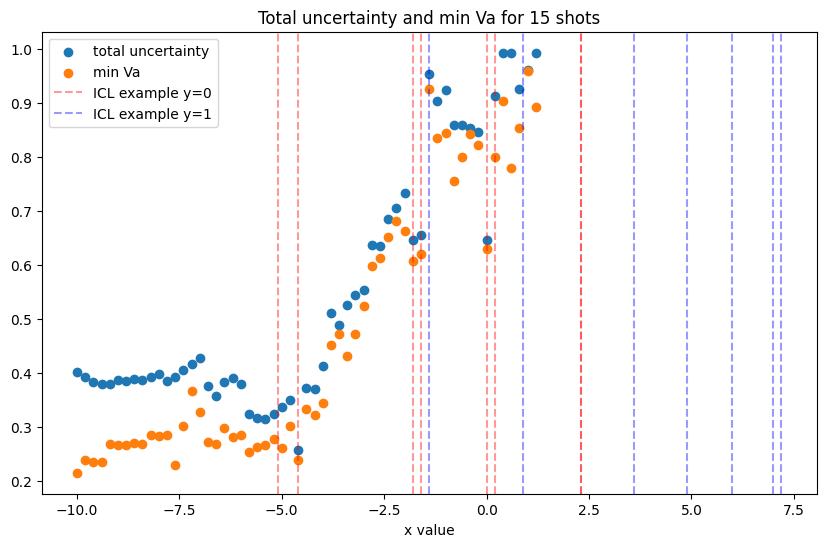

In [15]:
# plot x vs total uncertainty and min Va

plt.figure(figsize=(10, 6))
plt.scatter(shots_df['true_x'], shots_df['total_uncertainty'], label='total uncertainty')
plt.scatter(shots_df['true_x'], shots_df['min_Va'], label='min Va')

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = 'ICL example y=0'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='r', linestyle='--', alpha=0.4, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = 'ICL example y=1'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='b', linestyle='--', alpha=0.4, label=label_string)
plt.title(f"Total uncertainty and min Va for {shots} shots")

# plt.yscale('log')
plt.xlabel('x value')
plt.legend()
plt.show()

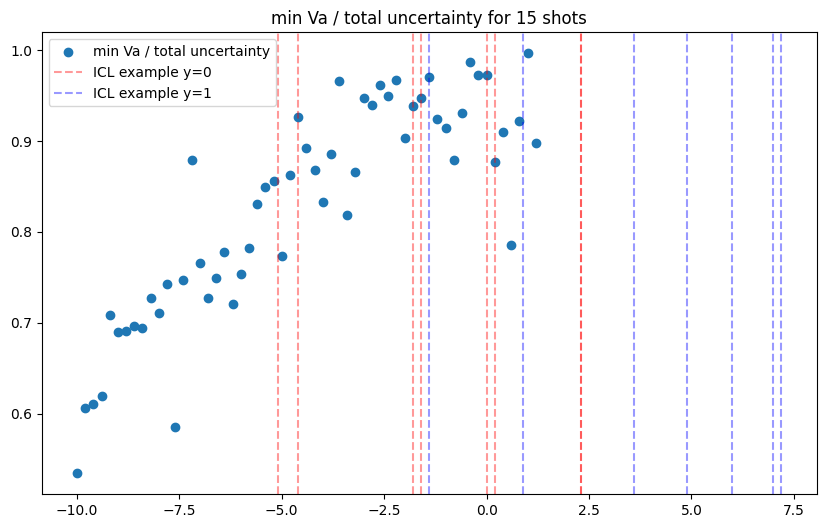

In [16]:
# min Va total uncertainty ratio

shots_df['min_Va_total_uncertainty_ratio'] = shots_df['min_Va'] / shots_df['total_uncertainty']

plt.figure(figsize=(10, 6))
plt.scatter(shots_df['true_x'], shots_df['min_Va_total_uncertainty_ratio'], label='min Va / total uncertainty')

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = 'ICL example y=0'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='r', linestyle='--', alpha=0.4, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = 'ICL example y=1'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='b', linestyle='--', alpha=0.4, label=label_string)
plt.title(f"min Va / total uncertainty for {shots} shots")

# plt.yscale('log')
plt.legend()
plt.show()

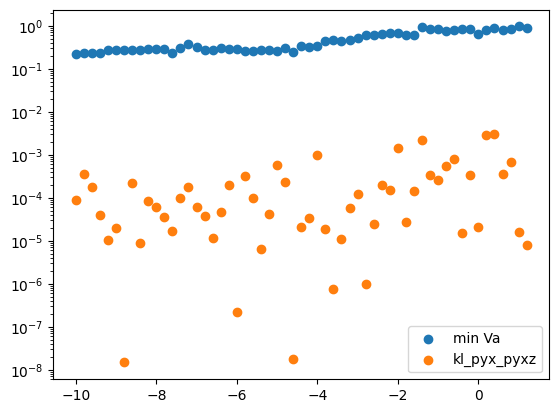

In [17]:
# plot x vs the kl divergence

plt.figure()
plt.scatter(shots_df['true_x'], shots_df['min_Va'], label='min Va')
plt.scatter(shots_df['true_x'], shots_df['kl_pyx_pyxz'], label='kl_pyx_pyxz')
plt.yscale('log')
plt.legend()
plt.show()


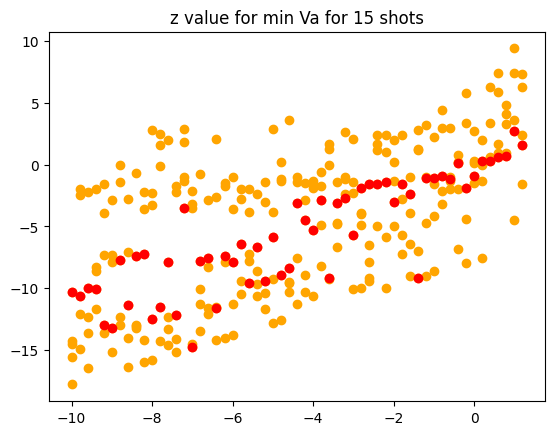

In [18]:
# plot x vs z_value_for_min_Va and within_threshold_values


plt.figure()
for i, row in shots_df.iterrows():
    x = row["true_x"]
    within_threshold = row["within_threshold"]
    for value in within_threshold:
        plt.scatter(x, value, c='orange')
plt.scatter(shots_df['true_x'], shots_df['z_value_for_min_Va'], c='r', label='z_value_for_min_Va')
plt.title(f"z value for min Va for {shots} shots")
plt.show()

In [19]:
df_list[1].loc[:, ['x1','kl_pyx_pyxz', 'Va = E[H[p(y|x,u,z)]]']]

KeyError: "['x1', 'Va = E[H[p(y|x,u,z)]]'] not in index"

In [ ]:
x_index = 5

In [ ]:
# Data for specific x values


# Load results
shot_values = []
total_uncertainty_list = []
min_Va_list = []
max_Ve_list = []
true_x_list = []

for filename in os.listdir(results_directory):
    if f"x{x_index}" in filename:
        z_df = pd.read_csv(results_directory + filename)
        # Get the shot value from the filename "_{shot_value}_shot"
        shot_value = int(re.search(r'results_(\d+)_shot', filename).group(1))
        shot_values.append(shot_value)
        
        total_uncertainty = z_df["H[p(y|x)]"].values[0]
        total_uncertainty_list.append(total_uncertainty)
        
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        true_x = z_df['true_x'].values[0]
        true_x_list.append(true_x)
        
# Create a dataframe from the lists
data = {'shot_values': shot_values,
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'true_x': true_x_list}

x_df = pd.DataFrame(data)

x_df = x_df.sort_values(by='shot_values')

FileNotFoundError: [Errno 2] No such file or directory: 'results/logistic_regression_3/experiment_6/'

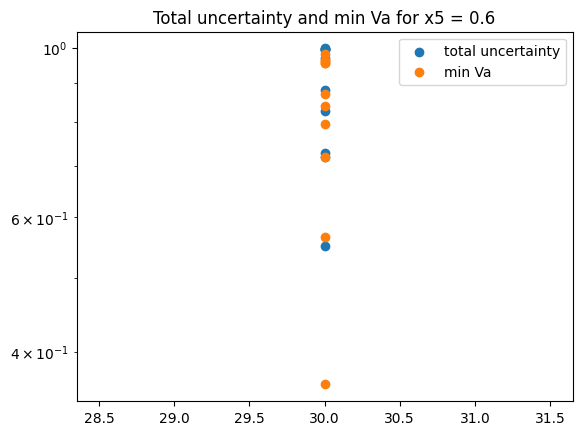

In [ ]:
# plot shot values vs total uncertainty and min Va

plt.figure()
plt.scatter(x_df['shot_values'], x_df['total_uncertainty'], label='total uncertainty')
plt.scatter(x_df['shot_values'], x_df['min_Va'], label='min Va')
plt.title(f"Total uncertainty and min Va for x{x_index} = {x_df['true_x'].values[0]}")
plt.yscale("log")
plt.legend()
plt.show()